# Logistic Regression

In this notebook we will learn:

- What is logistic regression
- How to run a logistic regression in Python
- How to interpret a logistic regression
- What are the assumptions of logistic regression



In [1]:
from datascience import *
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from scipy import stats

import pandas

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Logistic Regression

Suppose we have a binary response (like Survives or Dies, Male or Female, Smoker or Non-Smoker), then we have a numeric predictor.  How can we use this type of data to make predictions about the response.

First, turn your binary response into a 0-1 variable.  Which one should you make 0 and which one should be 1?  It literally doesn't matter, just pick one.  A common thing to do is to use the alphabetical order.  So Dead = 0 and Survived = 1, Female = 0 and Male = 1, so on.  But seriously, other than one response must be coded as a 0 and the other as a 1, there's no set rule here.  

Before getting to the analysis, let's discuss the mathematics.

First, it is used to "predict" the **probability** of one of two outcomes.

Why is it called "logistic" regression?  It's because it uses the logistical unit or  "logit" function:

$$ \ln\left(\frac{p}{1-p}\right)$$


If $\displaystyle p = \frac{1}{3}$ then the odds of $p$ are $\displaystyle \frac{\frac{1}{3}}{\frac{2}{3}} = \frac{1}{2} = 1:2$


If $p$ is the probability of event E occurring, then $\displaystyle \frac{p}{1-p}$ are the odds of E.  So the logit function is also called the log-odds.  

If $\displaystyle f(x) = \ln\left(\frac{x}{1-x}\right) $, what is $\displaystyle f^{-1}(x)$?

$$ \displaystyle  f(x)   = \ln\left(\frac{x}{1-x}\right) $$

$$y  \displaystyle = \ln\left(\frac{x}{1-x}\right) $$

$$ e^y  \displaystyle = \frac{x}{1-x} $$

$$ \displaystyle e^y - x e^y = x $$

$$ e^y  = x + x e^y $$

$$\displaystyle \frac{e^y}{1+e^y}  =  x $$

$$\displaystyle f^{-1}(x) = \frac{e^x}{1+e^x}$$

The model is:

$$\beta_0 + \beta_1 x = \ln\left(\frac{\hat{p}}{1-\hat{p}}\right)$$


This puts the logit function into a linear equation with the predictor.  

Why did we care what $\displaystyle f^{-1}(x) was?  Because the equation is usually rearranged when we make the graph for logistic regression.  

$$ \hat{p} = \frac{e^{\beta_0 + \beta_1 x}}{1+ e^{\beta_0 + \beta_1 x}} $$

In this form, the $y$-axis is $\hat{p}$ which makes interpretation easier.  

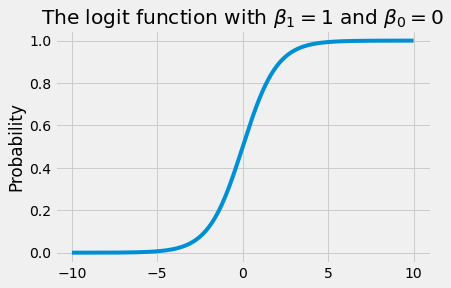

In [2]:
X = np.arange(-10, 10.001, 0.001)

def logit(x):
    return math.e**x/(1+math.e**x)

Y = logit(X)

plots.plot(X, Y)
plots.title(r"The logit function with $\beta_1 = 1$ and $\beta_0 = 0$")
plots.ylabel("Probability");

How do the values of $\beta_0$ and $\beta_1$ change the shape of the graph above?  Use the sliders below to investigate that.  

In [3]:
import ipywidgets as widgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(slope, intercept):
    x = np.linspace(-10, 10)
    y = math.e**(x*slope + intercept)/(1 +  math.e**(x*slope + intercept))
    plt.plot(x,y,  color="green")
    plt.ylim(-0.1,1.1)
    plt.xlim(-10,10) 
    #rmse = np.round((sum((yy - correlation*xx - intercept)**2)/(len(xx)-2))**0.5,2)
    #plt.plot(x, y)
    #plt.text(-1.5,1, f"RMSE = {rmse}", color="red", size='large')
    #plt.ylabel("Duration")
    #plt.xlabel("Wait")

interact(plot_func, slope = widgets.FloatSlider(value=1, min=-4, max=4, step=0.01), 

         intercept=widgets.FloatSlider(value=0, min=-8, max=8, step=0.050));



interactive(children=(FloatSlider(value=1.0, description='slope', max=4.0, min=-4.0, step=0.01), FloatSlider(v…

Using the births data set that we've used before, let's use the birth weight of the baby to try to predict if the mother smoked.  


First, the original births data set does contain a variable that indicates if the mother smoked, but it's Boolean.  We need it to be binary, meaning 0-1.  We already fixed this problem before when we created a so-called dummy variable for Smoker, we'll do that again. 

In [4]:
births = Table.read_table('baby.csv')

births.show(3)

def my_to_binary(x):
    ### converts an array of Trues and Falses to 1's and 0's ###
    return int(x)
    
births = births.with_column("Smoker Binary", births.apply(my_to_binary, "Maternal Smoker"))
births = births.where("Smoker Binary", are.contained_in(make_array(0,1)))

births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,Smoker Binary
120,284,27,62,100,False,0
113,282,33,64,135,False,0
128,279,28,64,115,True,1
108,282,23,67,125,True,1
136,286,25,62,93,False,0
138,244,33,62,178,False,0
132,245,23,65,140,False,0
120,289,25,62,125,False,0
143,299,30,66,136,True,1
140,351,27,68,120,False,0


In [5]:
import statsmodels.formula.api as smf
# Analysis of Variance (ANOVA) on linear models
#from statsmodels.stats.anova import anova_lm

## Prepare the data in the necessary format over the next few lines

Baby_weight = births.column("Birth Weight")
Smoker = births.column("Smoker Binary")


## On the next few lines, only edit the names of the arrays and variables
logistic_model_data = pandas.DataFrame({'Baby_Weight': Baby_weight, "Smoker": Smoker})
logistic_model = smf.logit("Smoker~Baby_Weight", data = logistic_model_data).fit()

# Print the summary
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.637774
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Smoker   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1172
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                 0.04693
Time:                        08:47:00   Log-Likelihood:                -748.75
converged:                       True   LL-Null:                       -785.62
                                        LLR p-value:                 8.900e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.0468      0.429      7.105      0.000       2.206       3.887
Baby_Weight    -0.0294    

In [6]:
logistic_model.predict()

array([0.38056237, 0.43020496, 0.32678585, ..., 0.31396275, 0.34651132,
       0.40159751])

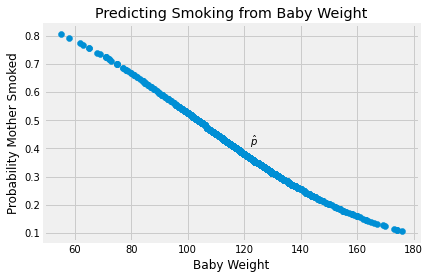

In [7]:
plots.scatter(Baby_weight, logistic_model.predict())
plots.xlabel("Baby Weight")
plots.ylabel("Probability Mother Smoked")
plots.title("Predicting Smoking from Baby Weight")
plots.text(122, 0.41, r"$\hat{p}$");

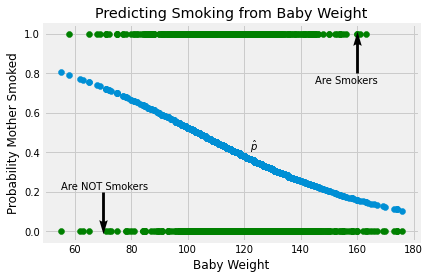

In [8]:
plots.scatter(Baby_weight, logistic_model.predict())
plots.scatter(Baby_weight, Smoker, color="green")
plots.quiver(160, 0.8, 0, 1, scale = 9)
plots.text(145, 0.75,"Are Smokers")
plots.quiver(70, 0.2, 0, -1, scale = 9)
plots.text(55, 0.21,"Are NOT Smokers")
plots.xlabel("Baby Weight")
plots.ylabel("Probability Mother Smoked")
plots.title("Predicting Smoking from Baby Weight")
plots.text(122, 0.41, r"$\hat{p}$");

## Using the predictions

How do we use the predictions?  Recall, the $\hat{p}$ that is model produces is an estimated probability of a whichever outcome is coded as a 1.  

Suppose we decide to classify a prediction as a 1 whenever $\hat{p} \geq 0.5$.  

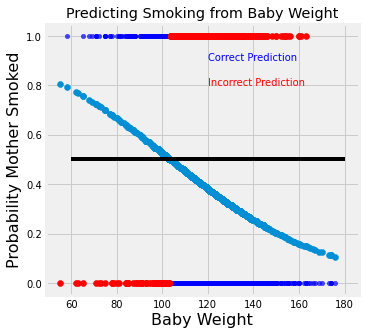

In [9]:
births = births.with_column("Boolean Prediction", logistic_model.predict() >=0.5)
births = births.with_column("Prediction", births.apply(my_to_binary, "Boolean Prediction"))
births = births.with_column("Agreement", births.column("Smoker Binary") == births.column("Prediction"))


#births.show(3)


births.where("Agreement", True).scatter("Birth Weight", "Smoker Binary", color="blue")
plots.scatter(births.where("Agreement", False).column("Birth Weight"), 
              births.where("Agreement", False).column("Smoker Binary"), color="red")
plots.scatter(Baby_weight, logistic_model.predict())
plots.plot([60, 180], [0.5, 0.5], color = "black")
plots.xlabel("Baby Weight")
plots.ylabel("Probability Mother Smoked")
plots.title("Predicting Smoking from Baby Weight")
plots.text(120, 0.9, "Correct Prediction", color = "blue")
plots.text(120, 0.8, "Incorrect Prediction", color = "red");

### Threshold 

The use of 0.5 as a cutoff for the classification is often referred to as a *threshold*.  We don't have to stick with 0.5, in some circumstances it makes sense to change the threshold.  Toward the end of this document, we'll consider the effects of changing the threshold.  

In [10]:
births.select("Maternal Smoker", "Boolean Prediction").pivot("Maternal Smoker", "Boolean Prediction")

C:\Users\bbailey\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array(tuple(values))
C:\Users\bbailey\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array(tuple(values))


Boolean Prediction,False,True
False,635,319
True,80,140


## Accessing the Model & The Confusion Matrix

There are a number of ways that a predictive model can be evaluated for desirable qualities.

First, we usually create a *confusion matrix*.  The output of the cell above is that *confusion matrix*.  From it we can start making the simpler calculations, such as the true positives, false positives, true negatives and false negatives.  


The number of **True Positives** is 140; this is the number of predicted True's that really are True.

The number of **False Positives** is 80; this is the number of predicted True's that are in fact False.

The number of **True Negatives** is 635; this is the number of False predictions that are really False.  

The number of **False Negatives** is 319; this is the number of False predictions that are really True.  

*Sensitivity* is the true positive rate.  $$Sensitivity = \frac{True\ Positives}{All\ Real\  Positives} $$

So in this case, $\displaystyle Sens = \frac{140}{140+319} \approx 0.305$.


*Specificity* is the true negative rate.  $$Specificity = \frac{True\ Negatives}{All\ Real\  Negatives} $$

In this case, $\displaystyle Spec = \frac{635}{635 + 80} \approx 0.888$.

So this model has better Specificity than Sensitivity.  In general, there is usually a trade-off between these two.  It's rare to have a model with both Specificity and Sensitivity being high.  


In [11]:
survey = Table.read_table("LogEx.csv")

survey.show(3)

boolean_gender = survey.column("Gender") == "m"

survey = survey.with_column("Boolean Gender", boolean_gender)

survey = survey.with_column("Binary Gender", survey.apply(my_to_binary, "Boolean Gender"))

survey = survey.drop("Boolean Gender")

survey.show(3)

Gender,Height
f,160
f,171.25
f,127


Gender,Height,Binary Gender
f,160,0
f,171.25,0
f,127,0


In [12]:
import statsmodels.formula.api as smf
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

## Prepare the data in the necessary format over the next few lines

Height = survey.column("Height")
Gender = survey.column("Binary Gender")


## On the next few lines, only edit the names of the arrays and variables
logistic_model_data = pandas.DataFrame({'Height': Height, "Gender": Gender})
logistic_model = smf.logit("Gender~Height", data = logistic_model_data).fit()

# Print the summary
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.410577
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                  119
Model:                          Logit   Df Residuals:                      117
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                  0.3376
Time:                        08:47:01   Log-Likelihood:                -48.859
converged:                       True   LL-Null:                       -73.761
                                        LLR p-value:                 1.699e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -30.8946      5.804     -5.323      0.000     -42.271     -19.518
Height         0.1747      0.

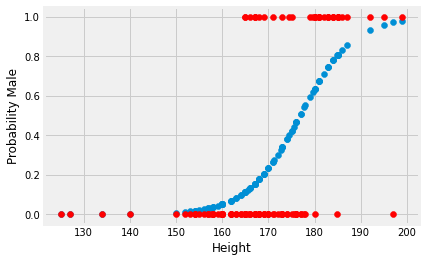

In [13]:
plots.scatter(Height, logistic_model.predict())
plots.scatter(Height, Gender, color = "red")
plots.ylabel("Probability Male")
plots.xlabel("Height");

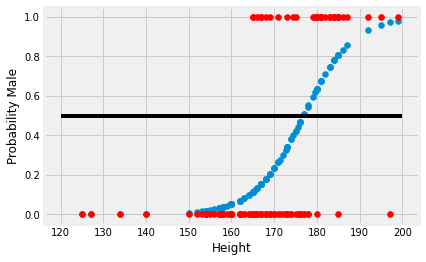

In [14]:
plots.scatter(Height, logistic_model.predict())
plots.scatter(Height, Gender, color = "red")
plots.ylabel("Probability Male")
plots.xlabel("Height")
plots.plot([120, 200], [0.5, 0.5], color="black");

In [15]:
survey = survey.with_column("Boolean Predictions", logistic_model.predict() >=0.5)
survey = survey.with_column("Predictions", survey.apply(my_to_binary, "Boolean Predictions"))
survey.select("Binary Gender", "Predictions").pivot("Binary Gender", "Predictions")

C:\Users\bbailey\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array(tuple(values))
C:\Users\bbailey\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array(tuple(values))


Predictions,0,1
0,75,12
1,7,25


The number of **True Positives** is 25.

The number of **False Positives** is 7.

The number of **True Negatives** is 75.  

The number of **False Negatives** is 12.  

*Sensitivity* is the true positive rate.  $$Sensitivity = \frac{True\ Positives}{All\ Real\ Positives} $$

So in this case, $\displaystyle Sens = \frac{25}{25+12} \approx 0.676$.


*Specificity* is the true negative rate.  $$Specificity = \frac{True\ Negatives}{All\ Real\ Negatives} $$

In this case, $\displaystyle Spec = \frac{75}{75+7} \approx 0.915$.

## Multiple Logistic Regression 

We can also do *multiple* logistic regression.  

In [16]:
import statsmodels.formula.api as sm
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

## Prepare the data in the necessary format over the next few lines

Height = births.column("Maternal Height")
Weight = births.column("Maternal Pregnancy Weight")
Baby_weight = births.column("Birth Weight")
Days = births.column("Gestational Days")
Age = births.column("Maternal Age")
Smoker = births.column("Smoker Binary")


## On the next few lines, only edit the names of the arrays and variables
logistic_model_data = pandas.DataFrame({'Baby_Weight': Baby_weight, 'Mom_weight':Weight,
                                       "Mom_height": Height, "Days":Days, "Age":Age,
                                       "Smoker": Smoker})
model1 = smf.logit(formula = "Smoker~Baby_Weight + Mom_weight + Mom_height + Days + Age", data = logistic_model_data).fit()

# Print the summary
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.630950
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Smoker   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1168
Method:                           MLE   Df Model:                            5
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                 0.05713
Time:                        08:47:01   Log-Likelihood:                -740.74
converged:                       True   LL-Null:                       -785.62
                                        LLR p-value:                 7.526e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.2807      1.978     -1.153      0.249      -6.158       1.596
Baby_Weight    -0.0334    

In [17]:
model2 = smf.logit(formula = "Smoker~Baby_Weight + Mom_weight + Mom_height +  Age", data = logistic_model_data).fit()

# Print the summary
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.631893
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Smoker   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1169
Method:                           MLE   Df Model:                            4
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                 0.05572
Time:                        08:47:01   Log-Likelihood:                -741.84
converged:                       True   LL-Null:                       -785.62
                                        LLR p-value:                 4.363e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.7298      1.675     -0.436      0.663      -4.013       2.553
Baby_Weight    -0.0310    

In [18]:
model3 = smf.logit(formula = "Smoker~Baby_Weight + Mom_height +  Age", data = logistic_model_data).fit()

# Print the summary
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.633156
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Smoker   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1170
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                 0.05383
Time:                        08:47:01   Log-Likelihood:                -743.33
converged:                       True   LL-Null:                       -785.62
                                        LLR p-value:                 3.187e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0133      1.618     -0.008      0.993      -3.184       3.158
Baby_Weight    -0.0313    

In [19]:
model3.predict() >=0.5

array([False, False, False, ..., False, False, False])

In [20]:
births = births.with_column("Predictions", model3.predict() >=0.5)
births.select("Maternal Smoker", "Predictions").pivot("Maternal Smoker", "Predictions")

C:\Users\bbailey\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array(tuple(values))
C:\Users\bbailey\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array(tuple(values))


Predictions,False,True
False,630,323
True,85,136


The number of **True Positives** is 136; remember,  this is the number of predicted True's that really are True.

The number of **False Positives** is 85; this is the number of predicted True's that are in fact False.

The number of **True Negatives** is 630; this is the number of False predictions that are really False.  

The number of **False Negatives** is 323; this is the number of False predictions that are really True.  

*Sensitivity* is the true positive rate.  $$Sensitivity = \frac{True\ Positives}{All\ Real\ Positives} $$

So in this case, $\displaystyle Sens = \frac{136}{136+323} \approx 0.296$.


*Specificity* is the true negative rate.  $$Specificity = \frac{True\ Negatives}{All\ Real\ Negatives} $$

In this case, $\displaystyle Spec = \frac{630}{630 + 85} \approx 0.881$.

So this model has better Specificity than Sensitivity.  In general, there is usually a trade-off between these two.  It's rare to have a model with both Specificity and Sensitivity being high.  

## Beyond Sensitivity and Specificity

Sensitivity and Specificity are interesting but they are not the only things people might care about.  

There's also:

*Positive Predictive Value* If a prediction is positive, what is the probability the observation is really positive. 

$$PPV = \frac{True\ Positives}{True\ Positives\ + \ False\ Positives}$$

*Negative Predictive Value* If a prediction is negative, what is the probability the observation is really negative.

$$NPV = \frac{True\ Negatives}{True\ Negatives\ + \ False\ Negatives}$$

There are even other measures that can be used to evaluate the quality of a predictive model, but for now, let's leave it with just these four.  


## Discussion Questions

Thinking about Sensitivity, Specificity, Positive Predictive Value and Negative Predictive Value, let's consider a medical test that is supposed to detect the presence of a disease.  Suppose the test isn't exactly perfect, like a logistic regression model, it looks at several factors and uses probability to determine if the test is positive (meaning the disease is present) or negative (meaning the disease is not present).  

1.  Suppose the disease was extremely deadly, if left untreated, but is easy to treat once detected.  What's more important, a high Sensitivity or high Specificity?


2.  Again, same disease: deadly when untreated, but easily treated.  What's more important, a high Positive Predictive Value or a Negative Predictive Value?


3.  Suppose the disease isn't very deadly at all and if left untreated the patient could get better without medical intervention, and even if the patient doesn't recover on his or her own at some time in the future, the symptoms will become more obvious, at which point the medical professionals will recognize the disease and begin the treatment.  Furthermore, the treatment is either very painful or extremely expensive.  Now what's more important,  a high Sensitivity or high Specificity?


4.  Same set up as 3, but this time what's more important, a high Positive Predictive Value or a Negative Predictive Value?


5.  Suppose the disease is extremely rare, say it only effects 1 in 100,000 people.  But *if* a patient has the disease it's important that the patient know it and seek treatment.  Of these four qualities that a test may have which is the most important?

## Changing the threshold

Besides systematically including or excluding predictors from the logistic model, another way we can optimize the model is to change the threshold for classification as a "1".  

Revisit the last model that we built to predict whether the mother was a smoker, and change the threshold first to 0.8, then to 0.2 and for both new thresholds:

- recompute the confusion matrix
- recompute Sensitivity and Specificity
- recompute the Positive Predictive Value and the Negative Predictive Value



## Assumptions of Logistic Regression

Before getting into the assumptions, first let me explain something else that will make the assumption seem more obvious.  That is, what is a Generalized Linear Model?

In its simplest form a generalized linear model (glm) is used in a situation where the outcome does not initially have a linear relationship with its predictors, *but* if we apply some function or transformation to the outcome variable, *then* it does. Logistic regression is a form of generalized linear models.  

Recall, that the relationship between $\hat{p}$ and $x$ in a logistic model is this:

$$ \hat{p} = \frac{e^{\beta_0 + \beta_1 x}}{1+ e^{\beta_0 + \beta_1 x}} $$

The right side of that equation is NOT linear at all.  But the right side of this is:

$$\ln\left(\frac{\hat{p}}{1-\hat{p}}\right) = \beta_0 + \beta_1 x $$

Generalized linear models utilize what is known as a link function, to turn the outcome into something that is linearly related to the assumed predictors.  In the case of logistic regression, that link function is the logit, $\displaystyle \ln\left(\frac{x}{1-x}\right)$; other glm's use other link functions.  Any discussion of this topic beyond what has been mentioned thus far is beyond the scope of this course, but if your interested and want to learn more you could later take an advanced course in regression. 

However, having explained the above, we can now simply state that the assumptions of logistic regression are essentially the same as the assumptions of linear regression, however, those assumptions are applied to $\displaystyle \ln\left(\frac{\hat{p}}{1-\hat{p}}\right) = \beta_0 + \beta_1 x $ instead of $\displaystyle \hat{y} = \beta_0 + \beta_1 x $.

   1. Linear relationship, but between $\displaystyle \ln\left(\frac{p}{1-p}\right) $ and predictors
    
   2. Residuals are normal with constant variance
    
   3. Independence between observations (no autocorrelation)